In [1]:
import os, fnmatch, cv2
import numpy as np
import matplotlib.pyplot as plt
from models import Noise2Same
os.environ['CUDA_VISIBLE_DEVICES']='4'

### Training
#### Load noisy images and perform normalization.

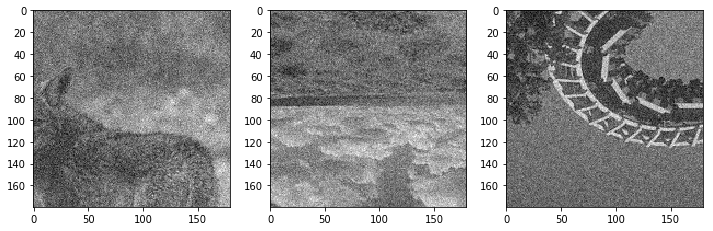

In [2]:
X = np.load('Denoising_data/BSD68/train/DCNN400_train_gaussian25.npy')
X_val = np.load('Denoising_data/BSD68/val/DCNN400_validation_gaussian25.npy')

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(X[0], cmap='gray');
plt.subplot(1,3,2)
plt.imshow(X[1], cmap='gray');
plt.subplot(1,3,3)
plt.imshow(X[2], cmap='gray');

In [3]:
X = np.array([(x - x.mean())/x.std() for x in X])
X_val = np.array([(x - x.mean())/x.std() for x in X_val]).astype('float32')

Build denoising model and start training. For this case, we set a different lambda and using the donut mask

In [4]:
model = Noise2Same('trained_models/', 'denoising_BSD68', dim=2, in_channels=1, lmbd=0.95, masking='donut')

In [5]:
model.train(X[...,None], patch_size=[64, 64], validation=X_val[...,None], batch_size=64, steps=80000)

### Testing/Evaluation
#### Load testing image and do evaluation.

In [6]:
groundtruth_data = np.load('Denoising_data/BSD68/test/bsd68_groundtruth.npy', allow_pickle=True)
test_data = np.load('Denoising_data/BSD68/test/bsd68_gaussian25.npy', allow_pickle=True)

In [7]:
def PSNR(gt, img):
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(255) - 10 * np.log10(mse)

def norm(x):
    x = (x-x.min())/(x.max()-x.min())
    return x

In [8]:
preds = [model.predict(d.astype('float32')) for d in test_data]

In [9]:
psnrs = [PSNR(preds[idx], groundtruth_data[idx]) for idx in range(len(test_data))]
print(np.array(psnrs).mean())

28.04219659262533


#### Visualizations

In the first row are the input noisy images, and in the second row are the denoised imags.

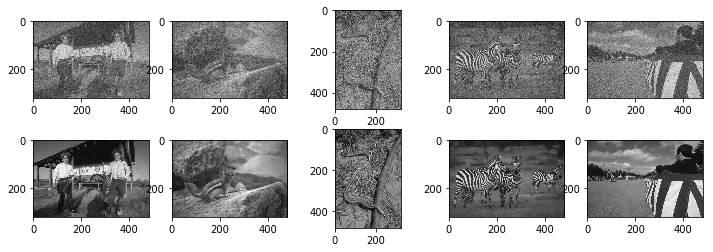

In [11]:
from utils.evaluation_utils import normalize

plt.figure(figsize=(12,4))
for i in range(5):
    idx = np.random.randint(len(test_data))
    plt.subplot(2,5,i+1)
    plt.imshow(test_data[idx], cmap='gray');
    plt.subplot(2,5,i+6)
    plt.imshow(normalize(preds[idx]), cmap='gray');